In [ ]:
# This notebook performs a statistical analysis during learning
# of mice under optoinhibition

In [ ]:
# run this on Colab
!rm -rf APE_paper/
!git clone https://github.com/HernandoMV/APE_paper.git
%pip install mouse-behavior-analysis-tools
%cd APE_paper/docs/figures_notebooks

In [12]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from os.path import exists
import urllib.request
import matplotlib.pylab as plt


from mouse_behavior_analysis_tools.utils import custom_functions as cuf
from mouse_behavior_analysis_tools.utils.misc_utils import update_progress
from mouse_behavior_analysis_tools.plot import make_figures

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# download data from server
dataset_name = 'Optoinhibition-through-learning_dataframe.csv'
url = "https://zenodo.org/record/7261639/files/" + dataset_name
dataset_path = '../../data/' + dataset_name
# download if data is not there
if not exists(dataset_path):
    print('Downloading data...')
    urllib.request.urlretrieve(url, dataset_path)
else:
    print('Data already in directory')
# load
otl_df = pd.read_csv(dataset_path, index_col=0)

Data already in directory


### Generate a dataset of random optostimulation choices
#### This is creating picking random choices, and matching trial number per session and difficulty, from trials in which there was no stimulation.
#### Compare this to the real data and get differences

In [3]:
# Specify the number of random datasets to do
n_times = 1000

# Compute the random dataframe
random_opto_df = cuf.get_random_dataframe_for_optostimulation(otl_df, n_times)

Adding info - Progress: [####################] 100.0%
Done computing the random dataframe


In [5]:
# fix the 'ceiling' effects, which occur because a mouse cannot move more to one side than 100% of the time
# and recalculate bias, mean and std

random_opto_df['bias_exp'] = None
random_opto_df['bias_mean_exp'] = None
random_opto_df['bias_std_exp'] = None

for sc, session in enumerate(pd.unique(random_opto_df['SessionID'])):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    # get data for opto
    opto_df = otl_df[(otl_df['SessionID'] == session) & (otl_df['OptoStim']==1)]
    trialsDif = np.array(opto_df['TrialHighPerc'])
    sideSelected = np.array(opto_df['FirstPoke'])
    difficulty, opto_perf = cuf.get_choices(sideSelected, trialsDif)
    
    mouse_line = random_opto_df.loc[session_idx].Genotype
    stim_side = random_opto_df.loc[session_idx].stimulated_side
    rand_difs = random_opto_df.loc[session_idx].Difficulties
    
    # select the difference to look at for this session
    # function to determine which difficulty to look at
    dif_to_consider = cuf.difficulty_for_bias(mouse_line, stim_side)
    dif_idx = list(rand_difs).index(dif_to_consider)
    opto_dif_idx = list(difficulty).index(dif_to_consider)
        
    # get data for the shuffles
    updown_list = np.empty(n_times)
    for i in range(n_times):
        y_vals = random_opto_df.loc[session_idx].Random_choices[i]
        updown_list[i] = y_vals[dif_idx] - opto_perf[opto_dif_idx]
    
    random_opto_df.at[session_idx, 'bias_exp'] = updown_list
    random_opto_df.at[session_idx, 'bias_mean_exp'] = np.nanmean(updown_list)
    random_opto_df.at[session_idx, 'bias_std_exp'] = np.nanstd(updown_list)
    
    update_progress((sc + 1) / len(pd.unique(random_opto_df['SessionID'])))


 - Progress: [####################] 100.0%


In [6]:
# compute contralateral bias again
random_opto_df['contralateral_bias_exp'] = None

for session in pd.unique(random_opto_df['SessionID']):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    # get information
    stim_side = otl_df[otl_df['SessionID'] == session].Stimulation.unique().item()

    # bias is the normal minus the opto. This means that a positive value is a leftwards bias of the opto trials
    # this is good as a contralateral bias for the trials in which optostimulation occurs in the right side
    # flip the sign of the ones where stimulation happens on the left
    if stim_side == 'Right':
        random_opto_df.at[session_idx, 'contralateral_bias_exp'] = random_opto_df.at[session_idx, 'bias_mean_exp']
    elif stim_side == 'Left':
        random_opto_df.at[session_idx, 'contralateral_bias_exp'] = - random_opto_df.at[session_idx, 'bias_mean_exp']
    else:
        print('Something wrong')

In [7]:
# add the performance of each session using only the normal (non stimulated) trials
random_opto_df['session_performance'] = None

for session in pd.unique(random_opto_df['SessionID']):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    # get data for non-opto trials
    normal_df = otl_df[(otl_df['SessionID'] == session) & (otl_df['OptoStim']==0)]
    # calculate performance
    sess_perf = 100 * np.nansum(normal_df.FirstPokeCorrect) / normal_df.shape[0]
    random_opto_df.at[session_idx, 'session_performance'] = sess_perf

In [8]:
# Create a new column that gives a unique identifier to each fiber
random_opto_df['fiber_id'] = [cuf.fiber_unique_id(random_opto_df.loc[x]) for x in random_opto_df.index.values]

In [9]:
# Calculate the contralateral significance of each session
random_opto_df['significance_value'] = [cuf.significance_calculator(random_opto_df.loc[x]) for x in random_opto_df.index.values]

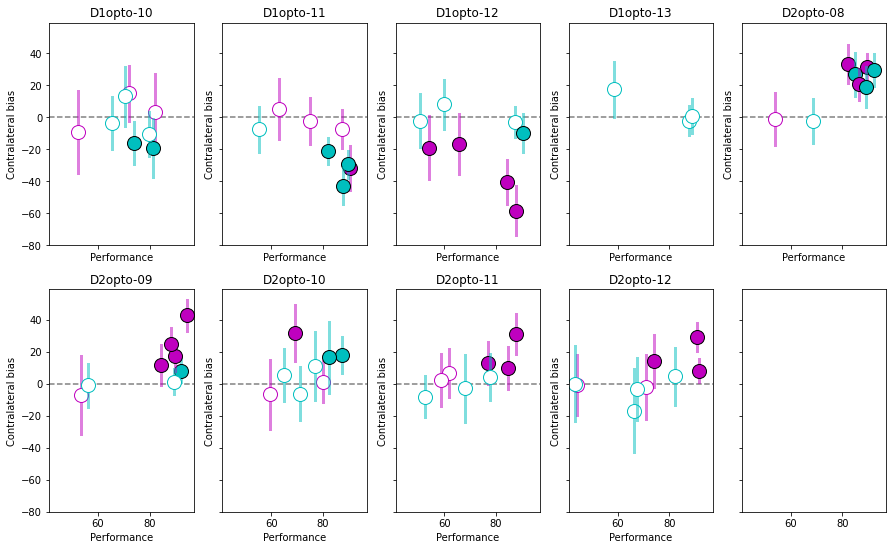

In [19]:
# plot data for each mouse
# Filled circles are significant sessions
# Cyan is right stimulation and magenta is left stimulation
significant_criteria = 0.05
fig = make_figures.make_figure_optoinhibition_through_learning_per_mouse(random_opto_df, significance=significant_criteria)
plt.show(fig)
# uncomment here to save the plot
# data_directory = ''
# plt.savefig(data_directory + 'optoinhibition_through_learning_per-mouse.pdf',
#             transparent=True, bbox_inches='tight')

In [20]:
# Select only those fibers that have at least one significant value.
# Those that have no effects we cannot be sure that stimulation worked.
# This effectively removes 4 fibers out of 17

fibers_to_keep = []

for fiber in np.unique(random_opto_df.fiber_id):
    if any(random_opto_df[random_opto_df.fiber_id == fiber].significance_value < significant_criteria):
        fibers_to_keep.append(fiber)

random_opto_df = random_opto_df[random_opto_df.fiber_id.isin(fibers_to_keep)]

#### Run a regression per fiber and calculate the significance by shuffling the performance

In [23]:
# create a new dataframe to hold the information necessary to generate individual regression lines,
# and to generate shuffled dataframes. This is a simplified version of the above

simplified_df = cuf.get_simplified_dataframe_for_optostimulation(random_opto_df)

In [26]:
# calculate slopes and generate shuffles of biases per mouse to get the significance for each individual
times_to_shuffle = 100
xs = range(50, 100) # values to make the predictions of the regression
reg_dicc = cuf.get_dicctionary_of_regressions_optostimulation(simplified_df, shuffle_times=times_to_shuffle, xs=xs)

In [27]:
# calculate a random distribution of slopes, combining both genotypes
# from the random fits, select one for each mouse, and get the mean
# out of that select mean and std
group_shuffle_times = 1000

num_of_animals = len(reg_dicc['predicted_matrices'])
group_shuffle_array = np.zeros([group_shuffle_times, len(xs)])

# for loop
for i in range(group_shuffle_times):
    shuffle_event_matrix = np.zeros([num_of_animals, len(xs)])
    for animal_counter in range(num_of_animals):
        # pick a random iteration of the matrix for that animal
        random_idx = np.random.choice(range(times_to_shuffle))
        shuffle_event_matrix[animal_counter, :] = reg_dicc['predicted_matrices'][animal_counter][random_idx, :]

    # append to the mean array
    group_shuffle_array[i, :] = np.mean(shuffle_event_matrix, axis=0)

# calculate mean and std
group_shuffle_mean = np.mean(group_shuffle_array, axis=0)
group_shuffle_std = np.mean(group_shuffle_array, axis=0)

#### Generate **Figure 7F**

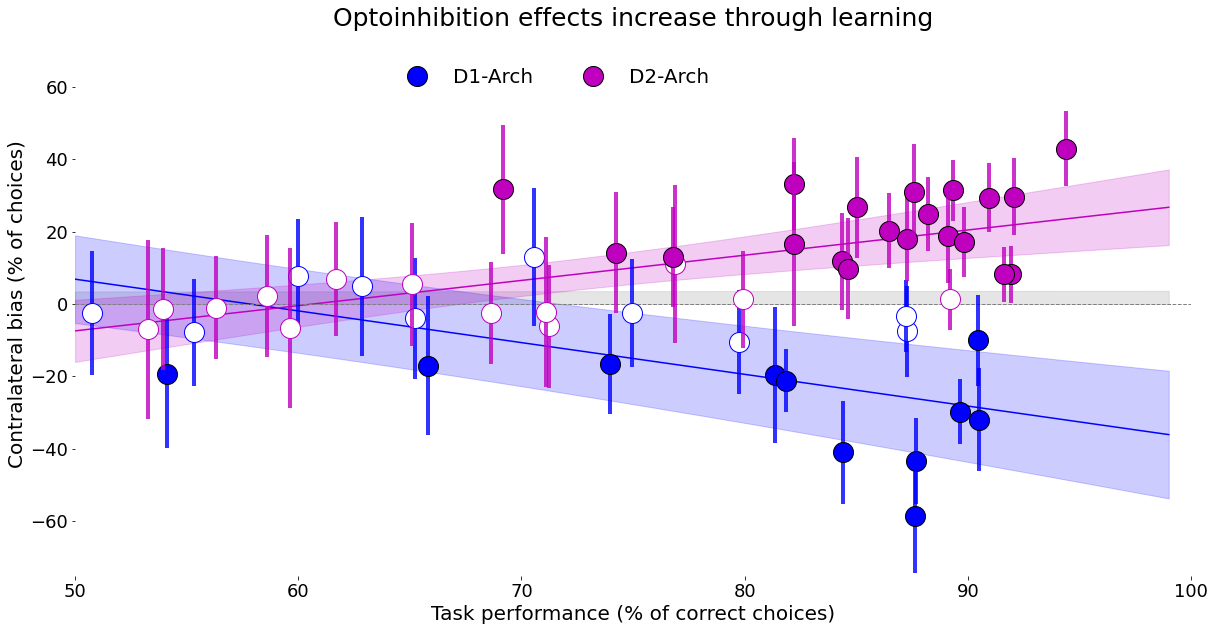

In [31]:
significant_criteria = 0.05
fig = make_figures.make_figure_optoinhibition_through_learning(random_opto_df,
                                                               reg_dicc,
                                                               xs,
                                                               group_shuffle_mean,
                                                               group_shuffle_std,
                                                               significance=significant_criteria,
                                                               colors=['b', 'm'])
plt.show(fig)
# uncomment here to save the plot
# data_directory = ''
# plt.savefig(data_directory + 'optoinhibition_through_learning.pdf',
#             transparent=True, bbox_inches='tight')

##### See pvalues for the slopes

In [32]:
# use d1 and d2 separately for this
genotypes = ['D1opto', 'D2opto']
n_times = 100000

for genotype in genotypes:
    # find indexes for that genotype
    gmask = np.where([g == genotype for g in reg_dicc['genotypes']])[0]

    # get the actual slope mean
    slopes_list = []
    for idx in gmask:
        slopes_list.append(reg_dicc['reg_coefs'][idx][0])
    slope_mean = np.mean(slopes_list)
    
    # generate random samples and note how many times it is more extreme
    cross_counter = 0
    for k in range(n_times):
        # randomly sample one for each animal
        slopes_list = []
        for idx in gmask:
            shuffled_slopes = reg_dicc['shuffled_coefficients'][idx][0]
            slopes_list.append(np.random.choice(shuffled_slopes))
        slope_mean_random = np.mean(slopes_list)
        if genotype == 'D1opto':
            if slope_mean_random <= slope_mean:
                cross_counter += 1
        if genotype == 'D2opto':
            if slope_mean_random >= slope_mean:
                cross_counter += 1
    
    print('Genotype {} slope is {}, with a p-value of {}'.format(genotype, slope_mean, cross_counter/n_times))

Genotype D1opto slope is -0.8752010759825792, with a p-value of 0.00044
Genotype D2opto slope is 0.6959761007590723, with a p-value of 0.00107


#### generate a binned session performance, grouping all the random choices for the sessions contained within

In [33]:
binned_df = cuf.get_binned_dataframe_for_optostimulation(random_opto_df, significance=significant_criteria)

In [34]:
# convert to a dataframe for plotting
sess_df = binned_df.groupby('performance_window').sum().reset_index()[['performance_window', 'n_sessions',
                                                                       'number_of_significant_sessions']]
sess_df['proportion_of_significant_sessions'] = 100 * sess_df.number_of_significant_sessions / sess_df.n_sessions

#### Generate **Figure 7G**

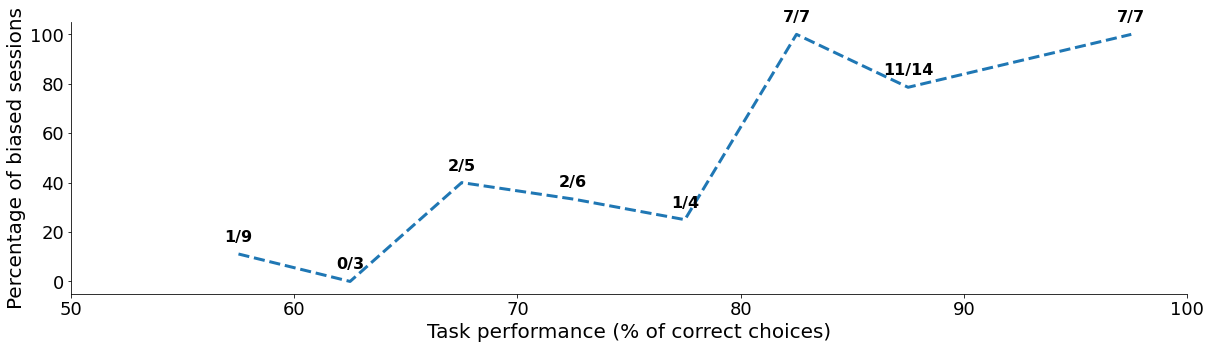

In [38]:
fig = make_figures.make_figure_optoinhibition_significant_sessions(sess_df)
plt.show(fig)
# uncomment here to save the plot
# data_directory = ''
# plt.savefig(data_directory + 'optoinhibition_through_learning_significant_sessions.pdf',
#             transparent=True, bbox_inches='tight')